#RNN para Classificação de sequências

**Base de dados utilizada:** https://huggingface.co/datasets/stanfordnlp/imdb

## Imports

In [3]:
import torch
import re
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim

from torch import nn
from datasets import load_dataset, concatenate_datasets, DatasetDict
from torch.utils.data import  Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from typing import List, Tuple

## Extração e Preprocessamento

In [4]:
class Tokenizer:
  def __init__(self):
    self.pattern = re.compile(r'\w+|[^\w\s]') # Returns an object of re.Pattern class

  def __call__(self, text) -> List[str]:
    return self.pattern.findall(text.lower())

In [5]:
class Vocabulary:
  def __init__(self, min_freq=1):
    self.min_freq = min_freq
    self.pad_idx = 1
    self.to_idx = {}
    self.to_token = {}
    self.specials = ['<unk>', '<pad>']
    for i, special in enumerate(self.specials):
      self.to_idx[special] = i
      self.to_token[i] = special

  def build_vocabulary(self, texts, tokenizer):
    counter = Counter() # Contador para hashtable objects

    for text in texts:
      tokens = tokenizer(text) # Divide o texto 'text' em tokens
      counter.update(tokens) # Atualiza a frequência dos tokens encontrados na variável tokens

    idx = len(self.specials)
    for token, freq in counter.items(): # Construção do vocabulário
      if freq >= self.min_freq:
        self.to_idx[token] = idx
        self.to_token[idx] = token
        idx += 1

    print(f"Vocabulário construído: {len(self.to_idx)} tokens.")

  def vocab_to_idx(self, text, tokenizer):
    tokens = tokenizer(text)
    return [self.to_idx.get(token, self.to_idx['<unk>']) for token in tokens]

In [6]:
def get_data(path:str = "stanfordnlp/imdb"):
  ds = load_dataset(path)
  return ds

In [7]:
ds = get_data()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [8]:
def split_data(ds, random_state:int = 42) -> Tuple:
  # Divisão em datasets de treino, validação e teste(70%, 15%, 15%)
  extra_train_ds = ds['test']
  split_ds = extra_train_ds.train_test_split(
      test_size=0.6,
      shuffle=True,
      seed=random_state,
      stratify_by_column='label'
  )
  train_ds = concatenate_datasets([ds['train'], split_ds['train']])

  val_test_ds = split_ds['test'].train_test_split(
      test_size=0.5,
      shuffle=True,
      seed=random_state,
      stratify_by_column='label'
  )
  final_ds = DatasetDict({
      'train' : train_ds,
      'validation' : val_test_ds['train'],
      'test' : val_test_ds['test']
  })

  train_ds = final_ds['train']
  val_ds = final_ds['validation']
  test_ds = final_ds['test']

  return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = split_data(ds)

In [10]:
def process_data(train_ds, val_ds, test_ds, batch_size:int):
  # Criando o vocabulário
  tokenizer = Tokenizer()
  vocab = Vocabulary(min_freq=5)

  vocab.build_vocabulary(train_ds['text'], tokenizer)

  # Função que processa o batch retornado do DataLoader
  def collate_fn(batch):
    labels = []
    texts = []
    lengths = []
    for sample in batch:
      labels.append(sample['label'])

      numerical_tokens = vocab.vocab_to_idx(sample['text'], tokenizer)
      if len(numerical_tokens) > 600: # Tamanho máximo da sequência
        numerical_tokens = numerical_tokens[:600]

      lengths.append(len(numerical_tokens))
      text_tensor = torch.tensor(numerical_tokens, dtype=torch.long)
      texts.append(text_tensor)

    texts_tensor = pad_sequence(texts, batch_first=True, padding_value=vocab.pad_idx)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)
    lengths_tensor = torch.tensor(lengths, dtype=torch.long)

    return texts_tensor, labels_tensor, lengths_tensor

  train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
  test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

  return train_dataloader, val_dataloader, test_dataloader, vocab

## Embeddings pré-treinados

In [11]:
# Download dos embeddings pré-treinados
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip -q glove.6B.zip

--2026-01-13 16:19:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.93MB/s    in 2m 43s  

2026-01-13 16:22:18 (5.03 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [12]:
def load_glove_matrix(vocab, embed_dim, glove_path):
    embeddings_index = {}
    try:
        with open(glove_path, 'r', encoding='utf8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
    except FileNotFoundError:
        print(f"ERRO: Arquivo {glove_path} não encontrado!")
        return None

    # Matriz inicializada aleatoriamente (para palavras que não estão no GloVe)
    weights_matrix = np.random.normal(scale=0.6, size=(len(vocab.to_idx), embed_dim))

    hits = 0
    misses = 0

    # Alinha ao vocabulário
    for word, i in vocab.to_idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            weights_matrix[i] = embedding_vector
            hits += 1
        else:
            if word == '<pad>':
                weights_matrix[i] = np.zeros(embed_dim)
            misses += 1

    print(f"Embeddings carregados. Hits: {hits}, Misses: {misses}")
    return torch.tensor(weights_matrix, dtype=torch.float32)

## Parâmetros

In [13]:
batch_size = 64
embed_dim = 100
hidden_dim = 64
num_layers = 2
output_dim = 1
epochs = 10
learning_rate = 0.001
dropout_rate = 0.5

## GRU Class

In [14]:
class GRU(nn.Module):
  def __init__(self, vocab_size, pad_idx, num_layers,
               input_dim, hidden_dim, dropout_rate, output_dim=1,pretrained_embeddings=None):
    super().__init__()

    # Treinar os embeddings(ou não)
    if pretrained_embeddings is not None:
        self.embedding = nn.Embedding.from_pretrained(
            pretrained_embeddings,
            padding_idx=pad_idx
        )
    else:
        self.embedding = nn.Embedding(vocab_size, input_dim, padding_idx=pad_idx)

    # Rede GRU
    self.gru = nn.GRU(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=num_layers, # posicionar 'num_layers' GRUs, uma seguida da outra
        batch_first=True,
        bidirectional=True
    )

    # Camada linear final para previsão(0 ou 1), concatenando a previsão de cada direção da GRU
    self.fc = nn.Linear(2*hidden_dim, output_dim)

    # Camada de Dropout
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, text, text_lengths):

    embedded = self.dropout(self.embedding(text))

    if isinstance(text_lengths, list):
      text_lengths = torch.Tensor(text_lengths)

    text_lengths_cpu = text_lengths.cpu()
    packed_embedded = nn.utils.rnn.pack_padded_sequence(
        embedded, text_lengths_cpu, batch_first=True, enforce_sorted=False
    ).cuda()

    output, hidden = self.gru(packed_embedded)

    # hidden: [num_layers, batch_size, hidden_dim] --> estado oculto de todas as camadas no último instante de tempo
    # output: [seq_length, batch_size, hidden_dim] --> camada de saída
    hidden_backward = hidden[-1, :, :] # estado oculto na última camada <--
    hidden_forward = hidden[-2, : , :] # estado oculto na última camada -->

    hidden_final = torch.cat((hidden_forward, hidden_backward), dim=1)

    return self.fc(self.dropout(hidden_final))


## Treinamento

In [21]:
def train_one_epoch(model, iterator, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_right = 0
    total_samples = 0
    for texts, labels, lengths in iterator:
        texts = texts.to(device)
        labels = labels.to(device)
        lengths = lengths.to(device)

        optimizer.zero_grad(set_to_none=True)
        predictions = model(texts, lengths).squeeze(1)
        loss = criterion(predictions, labels)
        total_loss += loss.item() * labels.size(0)

        probs = torch.sigmoid(predictions)
        predicted_classes = torch.round(probs)
        correct_tensor = (predicted_classes == labels)
        total_right += correct_tensor.sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / total_samples
    avg_acc = total_right / total_samples
    return avg_loss, avg_acc

In [16]:
def validate_one_epoch(model, iterator, criterion, device):
    model.eval()
    total_loss = 0
    total_right = 0
    total_samples = 0
    with torch.no_grad():
        for texts, labels, lengths in iterator:
            texts = texts.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            predictions = model(texts, lengths).squeeze(1)
            loss = criterion(predictions, labels)
            total_loss += loss.item() * labels.size(0)

            probs = torch.sigmoid(predictions)
            predicted_classes = torch.round(probs)
            correct_tensor = (predicted_classes == labels)
            total_right += correct_tensor.sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_right / total_samples
    return avg_loss, avg_acc

In [22]:
# Preparo dos dados
train_loader, val_loader, test_loader, vocab = process_data(train_ds, val_ds, test_ds, batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")


start_time = time.time()

# --- EXPERIMENTO 1: Treinar Embeddings do Zero ---
print("\n--- Modelo com Embeddings do Zero ---")
model_scratch = GRU(
    len(vocab.to_idx), vocab.pad_idx, num_layers,
    embed_dim, hidden_dim, dropout_rate, output_dim, pretrained_embeddings=None
).to(device)

opt_scratch = optim.Adam(model_scratch.parameters(), lr=learning_rate)
crit = nn.BCEWithLogitsLoss()

train_avg_losses_scratch = []
val_avg_losses_scratch = []
train_avg_acc_scratch = []
val_avg_acc_scratch = []
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model_scratch, train_loader, opt_scratch, crit, device)
    val_loss, val_acc = validate_one_epoch(model_scratch, val_loader, crit, device)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    train_avg_losses_scratch.append(train_loss)
    val_avg_losses_scratch.append(val_loss)
    train_avg_acc_scratch.append(train_acc)
    val_avg_acc_scratch.append(val_acc)

end_time = time.time()

elapsed_time = end_time - start_time

print(f"Tempo de treinamento SEM embeddings pré-treinados: {elapsed_time:.4f} segundos")


# --- EXPERIMENTO 2: Com Embeddings GloVe ---
print("\n--- Modelo com Embeddings GloVe Pré-Treinados ---")
assert embed_dim == 50 or embed_dim == 100 or embed_dim == 200 or embed_dim == 300
glove_weights = load_glove_matrix(vocab, embed_dim, f'/content/glove.6B.{embed_dim}d.txt')

crit = nn.BCEWithLogitsLoss()
start_time = time.time()

model_glove = GRU(
    len(vocab.to_idx), vocab.pad_idx, num_layers,
    embed_dim, hidden_dim, dropout_rate, output_dim,pretrained_embeddings=glove_weights
).to(device)

opt_glove = optim.Adam(model_glove.parameters(),lr=learning_rate)

train_avg_losses_glove = []
val_avg_losses_glove = []
train_avg_acc_glove = []
val_avg_acc_glove = []
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model_glove, train_loader, opt_glove, crit, device)
    val_loss, val_acc = validate_one_epoch(model_glove, val_loader, crit, device)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    train_avg_losses_glove.append(train_loss)
    val_avg_losses_glove.append(val_loss)
    train_avg_acc_glove.append(train_acc)
    val_avg_acc_glove.append(val_acc)

end_time = time.time()

elapsed_time = end_time - start_time

print(f"Tempo de treinamento COM embeddings pré-treinados: {elapsed_time:.4f} segundos")

Vocabulário construído: 34196 tokens.
Usando: cuda

--- Modelo com Embeddings do Zero ---
Epoch 1 | Train Loss: 0.6439 | Val Loss: 0.5270
Epoch 2 | Train Loss: 0.4494 | Val Loss: 0.3243
Epoch 3 | Train Loss: 0.3261 | Val Loss: 0.2817
Epoch 4 | Train Loss: 0.2778 | Val Loss: 0.2658
Epoch 5 | Train Loss: 0.2464 | Val Loss: 0.2356
Epoch 6 | Train Loss: 0.2195 | Val Loss: 0.2219
Epoch 7 | Train Loss: 0.2071 | Val Loss: 0.2668
Epoch 8 | Train Loss: 0.1821 | Val Loss: 0.2209
Epoch 9 | Train Loss: 0.1754 | Val Loss: 0.2358
Epoch 10 | Train Loss: 0.1560 | Val Loss: 0.2233
Tempo de treinamento SEM embeddings pré-treinados: 542.1739 segundos

--- Modelo com Embeddings GloVe Pré-Treinados ---
Embeddings carregados. Hits: 33425, Misses: 771
Epoch 1 | Train Loss: 0.5350 | Val Loss: 0.3624
Epoch 2 | Train Loss: 0.3962 | Val Loss: 0.3661
Epoch 3 | Train Loss: 0.3622 | Val Loss: 0.2935
Epoch 4 | Train Loss: 0.3384 | Val Loss: 0.3248
Epoch 5 | Train Loss: 0.3178 | Val Loss: 0.2591
Epoch 6 | Train Loss:

In [23]:
def plot_train_val_losses(train_avg_losses, val_avg_losses, num_epochs):
  epochs = list(range(1, num_epochs+1))
  plt.plot(epochs, train_avg_losses, color='blue', label='Loss do treino')
  plt.plot(epochs, val_avg_losses, color='orange', label='Loss da validação')
  plt.title('Losses de treino e validação por época de treino')
  plt.legend()

In [24]:
def plot_train_val_accuracies(train_avg_acc, val_avg_acc, num_epochs):
  epochs = list(range(1, num_epochs+1))
  plt.plot(epochs, train_avg_acc, color='blue', label='Acurácia do treino')
  plt.plot(epochs, val_avg_acc, color='orange', label='Acurácia da validação')
  plt.title('Acurácias de treino e validação por época de treino')
  plt.legend()

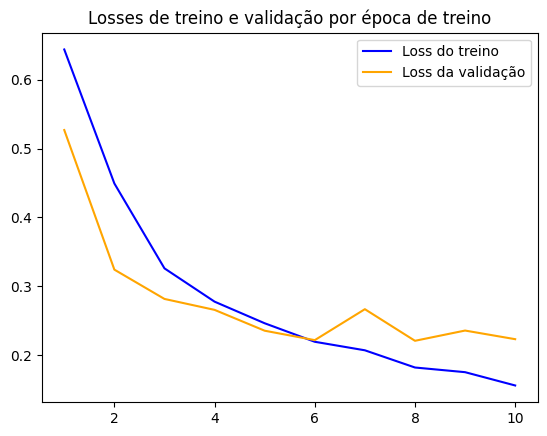

In [25]:
plot_train_val_losses(train_avg_losses_scratch, val_avg_losses_scratch, epochs)

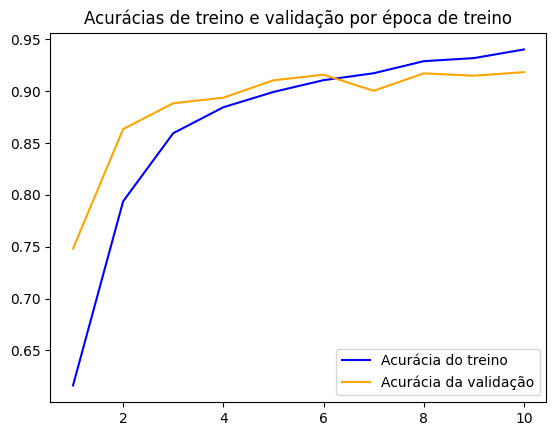

In [26]:
plot_train_val_accuracies(train_avg_acc_scratch, val_avg_acc_scratch, epochs)

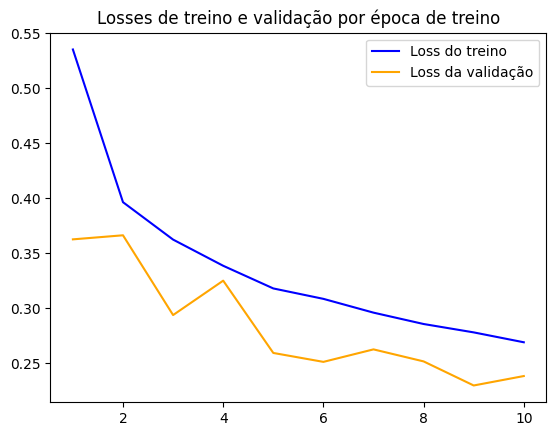

In [27]:
plot_train_val_losses(train_avg_losses_glove, val_avg_losses_glove, epochs)

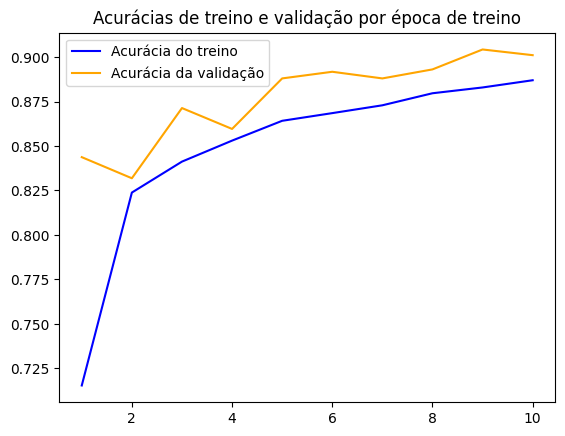

In [28]:
plot_train_val_accuracies(train_avg_acc_glove, val_avg_acc_glove, epochs)

## Teste

In [30]:
def get_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  recall = tp/(tp+fn)
  precision = tp/(tp+fp)
  f1 = (2*recall*precision)/(recall+precision)
  return {'acc':acc,'precision':precision,'f1-score':f1}

In [31]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Blues', xticklabels=['Predicted Positive', 'Predicted Negative'], yticklabels=['Actual Positive', 'Actual Negative'], fmt='')
  return

In [32]:
def evaluate_test_set(model, iterator, criterion, device):
  model.eval()

  total_correct = 0
  total_samples = 0

  all_preds = []
  all_labels = []

  with torch.no_grad():
      for texts, labels, lengths in iterator:
          texts = texts.to(device)
          labels = labels.to(device)
          lengths = lengths.to(device)

          predictions = model(texts, lengths).squeeze(1)

          # Cálculo da loss
          loss = criterion(predictions, labels)

          # Cálculo da acurácia
          probs = torch.sigmoid(predictions)
          predicted_classes = torch.round(probs)
          correct = (predicted_classes == labels).sum().item()

          total_correct += correct
          total_samples += labels.size(0)

          # Armazenamento das labels e previsões
          all_preds.extend(predicted_classes.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  avg_acc = total_correct / total_samples
  return avg_acc, np.array(all_labels), np.array(all_preds)

In [33]:
avg_acc, y_true, y_pred = evaluate_test_set(model_scratch, test_loader, crit, device)

In [34]:
get_metrics(y_true, y_pred)

{'acc': np.float64(0.9136),
 'precision': np.float64(0.891271442986882),
 'f1-score': np.float64(0.9159968887736584)}

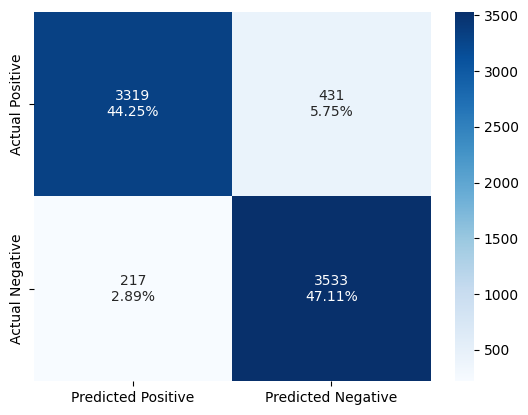

In [35]:
plot_confusion_matrix(y_true, y_pred)

In [36]:
avg_acc, y_true, y_pred = evaluate_test_set(model_glove, test_loader, crit, device)

In [37]:
get_metrics(y_true, y_pred)

{'acc': np.float64(0.9008),
 'precision': np.float64(0.8755622188905547),
 'f1-score': np.float64(0.9040247678018577)}

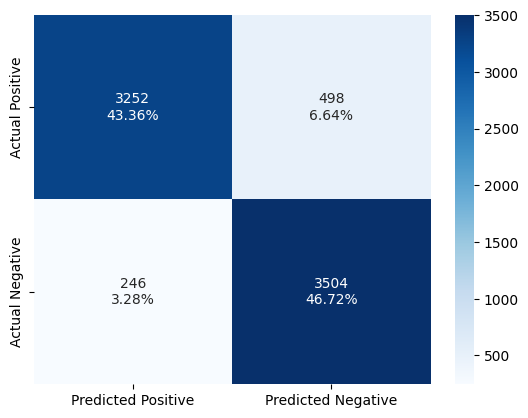

In [38]:
plot_confusion_matrix(y_true, y_pred)